In [1]:
import os
import numpy as np
import scipy.io
import tensorflow as tf
import h5py
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from numpy import inf, nan
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable
from mpl_toolkits.axes_grid1 import make_axes_locatable
%run parula_map.ipynb

In [2]:
# Run GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf_device = '/gpu:0'

In [3]:
@register_keras_serializable()
class APT(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense_21 = tf.keras.layers.Dense(512, activation='relu')
        self.dense_22 = tf.keras.layers.Dense(512, activation='relu')
        self.dense_23 = tf.keras.layers.Dense(512, activation='relu')
        self.dense_24 = tf.keras.layers.Dense(512, activation='relu')
        self.dense_3 = tf.keras.layers.Dense(4, activation='sigmoid')

    def build(self, input_shape):
        super().build(input_shape)
        
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_21(x)
        x = self.dense_22(x)
        x = self.dense_23(x)
        x = self.dense_24(x)
        x = self.dense_3(x)
        max_4 = tf.constant([500,  0.0045,  1,  0.5])
        min_4 = tf.constant([5,  9.1e-06, 0.01, -0.5 ])
        out_denorm = tf.math.multiply(x, max_4-min_4) + min_4
        return out_denorm
    

In [4]:
@register_keras_serializable()
class MTC(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense_21 = tf.keras.layers.Dense(512, activation='relu')
        self.dense_22 = tf.keras.layers.Dense(512, activation='relu')
        self.dense_23 = tf.keras.layers.Dense(512, activation='relu')
        self.dense_24 = tf.keras.layers.Dense(512, activation='relu')
        self.dense_3 = tf.keras.layers.Dense(4, activation='sigmoid')

    def build(self, input_shape):
        super().build(input_shape)
        
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_21(x)
        x = self.dense_22(x)
        x = self.dense_23(x)
        x = self.dense_24(x)
        x = self.dense_3(x)
        max_4 = tf.constant([100, 0.17, 10e-05, 3])
        min_4 = tf.constant([5, 0.02, 1e-06, 0.2])
        out_denorm = tf.math.multiply(x, max_4-min_4) + min_4
        return out_denorm


In [5]:
model_APT = APT()
model_APT.build((None,103))

In [6]:
model_MTC = MTC()
model_MTC.build((None,103 ))

In [11]:
## Load model weights
current_directory = os.getcwd()

APT_model_path = os.path.join(current_directory, 'Model', 'ST_MRF_103MTC_103APT_PR_APT_weights_vf.weights.h5')
MTC_model_path = os.path.join(current_directory, 'Model', 'ST_MRF_103MTC_103APT_PR_MTC_weights_vf.weights.h5')

model_APT.load_weights(APT_model_path)
model_MTC.load_weights(MTC_model_path)

In [12]:
# Adding noise using target SNR
def add_noise(x_volts, target_snr_db):
# Set a target SNR
    x_watts = x_volts ** 2
    # Calculate signal power and convert to dB 
    sig_avg_watts = np.mean(x_watts)
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    # Generate an sample of white noise
    mean_noise = 0
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
    return noise_volts

def mtc_mrf_noisy(mtc, snr):
    for i in range(np.shape(mtc)[0]):
        ### Add noise
        noise_volts = add_noise(mtc[i,:], snr)  ## signal, desired SNR
        y_volts = mtc + noise_volts
        return y_volts
        
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) 

In [23]:
## Path for GT MTC and APT phantoms
simulated_phantom_kmw_data_path = os.path.join(current_directory, 'Simulated data', 'MTC_GT_Rm_full.mat')
simulated_phantom_Fm_data_path = os.path.join(current_directory, 'Simulated data', 'MTC_GT_Mm_full.mat')
simulated_phantom_T2m_data_path = os.path.join(current_directory, 'Simulated data', 'MTC_GT_T2m_full.mat')
simulated_phantom_T1w_data_path = os.path.join(current_directory, 'Simulated data', 'MTC_GT_T1_full.mat')
simulated_phantom_ksw_data_path = os.path.join(current_directory, 'Simulated data', 'GT_Rc_SL2_103DS.mat')
simulated_phantom_Fs_data_path = os.path.join(current_directory, 'Simulated data', 'GT_Mc_SL2_103DS.mat')
simulated_phantom_T2s_data_path = os.path.join(current_directory, 'Simulated data', 'GT_T2c_SL2_103DS.mat')
simulated_phantom_dB0_data_path = os.path.join(current_directory, 'Simulated data', 'GT_B0_SL2_103DS.mat')

## Load GT MTC Phantom
kmw_file = scipy.io.loadmat(simulated_phantom_kmw_data_path)
Phantom_kmw = kmw_file['Rm_fixed1']   
Fm_file = scipy.io.loadmat(simulated_phantom_Fm_data_path)
Phantom_Fm = Fm_file['Mm_fixed1']   
T2m_file = scipy.io.loadmat(simulated_phantom_T2m_data_path)
Phantom_T2m = T2m_file['T2m_fixed1']   
T1w_file = scipy.io.loadmat(simulated_phantom_T1w_data_path)
Phantom_T1w = T1w_file['T1_fixed1']  

## Load GT APT Phantom
ksw_file = scipy.io.loadmat(simulated_phantom_ksw_data_path)
Phantom_ksw = ksw_file['Rc_fixed1']   
Fs_file = scipy.io.loadmat(simulated_phantom_Fs_data_path)
Phantom_Fs = Fs_file['Mc_fixed1']   
T2s_file = scipy.io.loadmat(simulated_phantom_T2s_data_path)
Phantom_T2s = T2s_file['T2c_fixed1']   
dB0_file = scipy.io.loadmat(simulated_phantom_dB0_data_path)
Phantom_dB0 = dB0_file['B0_fixed1'] 

## load ST-MRF data
simulated_ST_MRF_data_path = os.path.join(current_directory, 'Simulated data', 'final_data.mat')
ST_MRF_data = scipy.io.loadmat(simulated_ST_MRF_data_path)

# Extract individual variables from the ST-MRF data
st_mrf_kmw = ST_MRF_data['st_mrf_kmw_fixed_reaggranged']
st_mrf_Fm = ST_MRF_data['st_mrf_Fm_fixed_reaggranged']
st_mrf_T2m = ST_MRF_data['st_mrf_T2m_fixed_reaggranged']
st_mrf_T1w = ST_MRF_data['st_mrf_T1w_fixed_reaggranged']
st_mrf_ksw = ST_MRF_data['st_mrf_ksw_fixed_reaggranged']
st_mrf_Fs = ST_MRF_data['st_mrf_Fs_fixed_reaggranged']
st_mrf_T2s = ST_MRF_data['st_mrf_T2s_fixed_reaggranged']
st_mrf_dB0 = ST_MRF_data['st_mrf_dB0_fixed_reaggranged']

## Add noise: SNR in dB
st_mrf_kmw_noisy = mtc_mrf_noisy(st_mrf_kmw, 47)
st_mrf_Fm_noisy = mtc_mrf_noisy(st_mrf_Fm, 47)
st_mrf_T2m_noisy = mtc_mrf_noisy(st_mrf_T2m, 47)
st_mrf_T1w_noisy = mtc_mrf_noisy(st_mrf_T1w, 47)
st_mrf_ksw_noisy = mtc_mrf_noisy(st_mrf_ksw, 47)
st_mrf_Fs_noisy = mtc_mrf_noisy(st_mrf_Fs, 47)
st_mrf_T2s_noisy = mtc_mrf_noisy(st_mrf_T2s, 47)
st_mrf_dB0_noisy = mtc_mrf_noisy(st_mrf_dB0, 47)

## Predict MTC and APT parameters from noisy ST-MRF signals
x_pred_st_mrf_kmw_noisy = model_MTC.predict(st_mrf_kmw_noisy)
test_kmw_reshaped = np.transpose(np.reshape(x_pred_st_mrf_kmw_noisy[:,0], [256,256]))    ## Select only kmw
x_pred_st_mrf_Fm_noisy = model_MTC.predict(st_mrf_Fm_noisy)
test_Fm_reshaped = np.transpose(np.reshape(x_pred_st_mrf_Fm_noisy[:,1], [256,256]))      ## Select only Fm
x_pred_st_mrf_T2m_noisy = model_MTC.predict(st_mrf_T2m_noisy)
test_T2m_reshaped = np.transpose(np.reshape(x_pred_st_mrf_T2m_noisy[:,2], [256,256]))    ## Select only T2m
x_pred_st_mrf_T1w_noisy = model_MTC.predict(st_mrf_T1w_noisy)
test_T1w_reshaped = np.transpose(np.reshape(x_pred_st_mrf_T1w_noisy[:,3], [256,256]))   ## Select only T1w

x_pred_st_mrf_ksw_noisy = model_APT.predict(st_mrf_ksw_noisy)
test_ksw_reshaped = np.transpose(np.reshape(x_pred_st_mrf_ksw_noisy[:,0], [256,256]))   ## Select only ksw
x_pred_st_mrf_ksw_noisy = model_APT.predict(st_mrf_Fs_noisy)
test_Fs_reshaped = np.transpose(np.reshape(x_pred_st_mrf_ksw_noisy[:,1], [256,256]))    ## Select only Fs
x_pred_st_mrf_T2s_noisy = model_APT.predict(st_mrf_T2s_noisy)
test_T2s_reshaped = np.transpose(np.reshape(x_pred_st_mrf_T2s_noisy[:,2], [256,256]))   ## Select only T2s
x_pred_st_mrf_dB0_noisy = model_APT.predict(st_mrf_dB0_noisy)
test_dB0_reshaped = np.transpose(np.reshape(x_pred_st_mrf_dB0_noisy[:,3], [256,256]))   ## Select only dB0

## Load model weights again if received memory related warning 

2048/2048 ━━━━━━━━━━━━━━━━━━━━ 2s 810us/step
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 2s 793us/step
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 2s 781us/step
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 2s 794us/step
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 2s 794us/step
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 2s 795us/step
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 2s 791us/step
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 2s 786us/step


In [24]:
## Apply mask to make background black
test_ksw_reshaped[Phantom_kmw==0]=0
test_Fs_reshaped[Phantom_kmw==0]=0
test_T2s_reshaped[Phantom_kmw==0]=0
test_dB0_reshaped[Phantom_kmw==0]=0.5

test_T1w_reshaped[Phantom_kmw==0]=0
test_T2m_reshaped[Phantom_kmw==0]=0
test_Fm_reshaped[Phantom_kmw==0]=0
test_kmw_reshaped[Phantom_kmw==0]=0

Text(0, 0.5, 'GT Fs (%)')

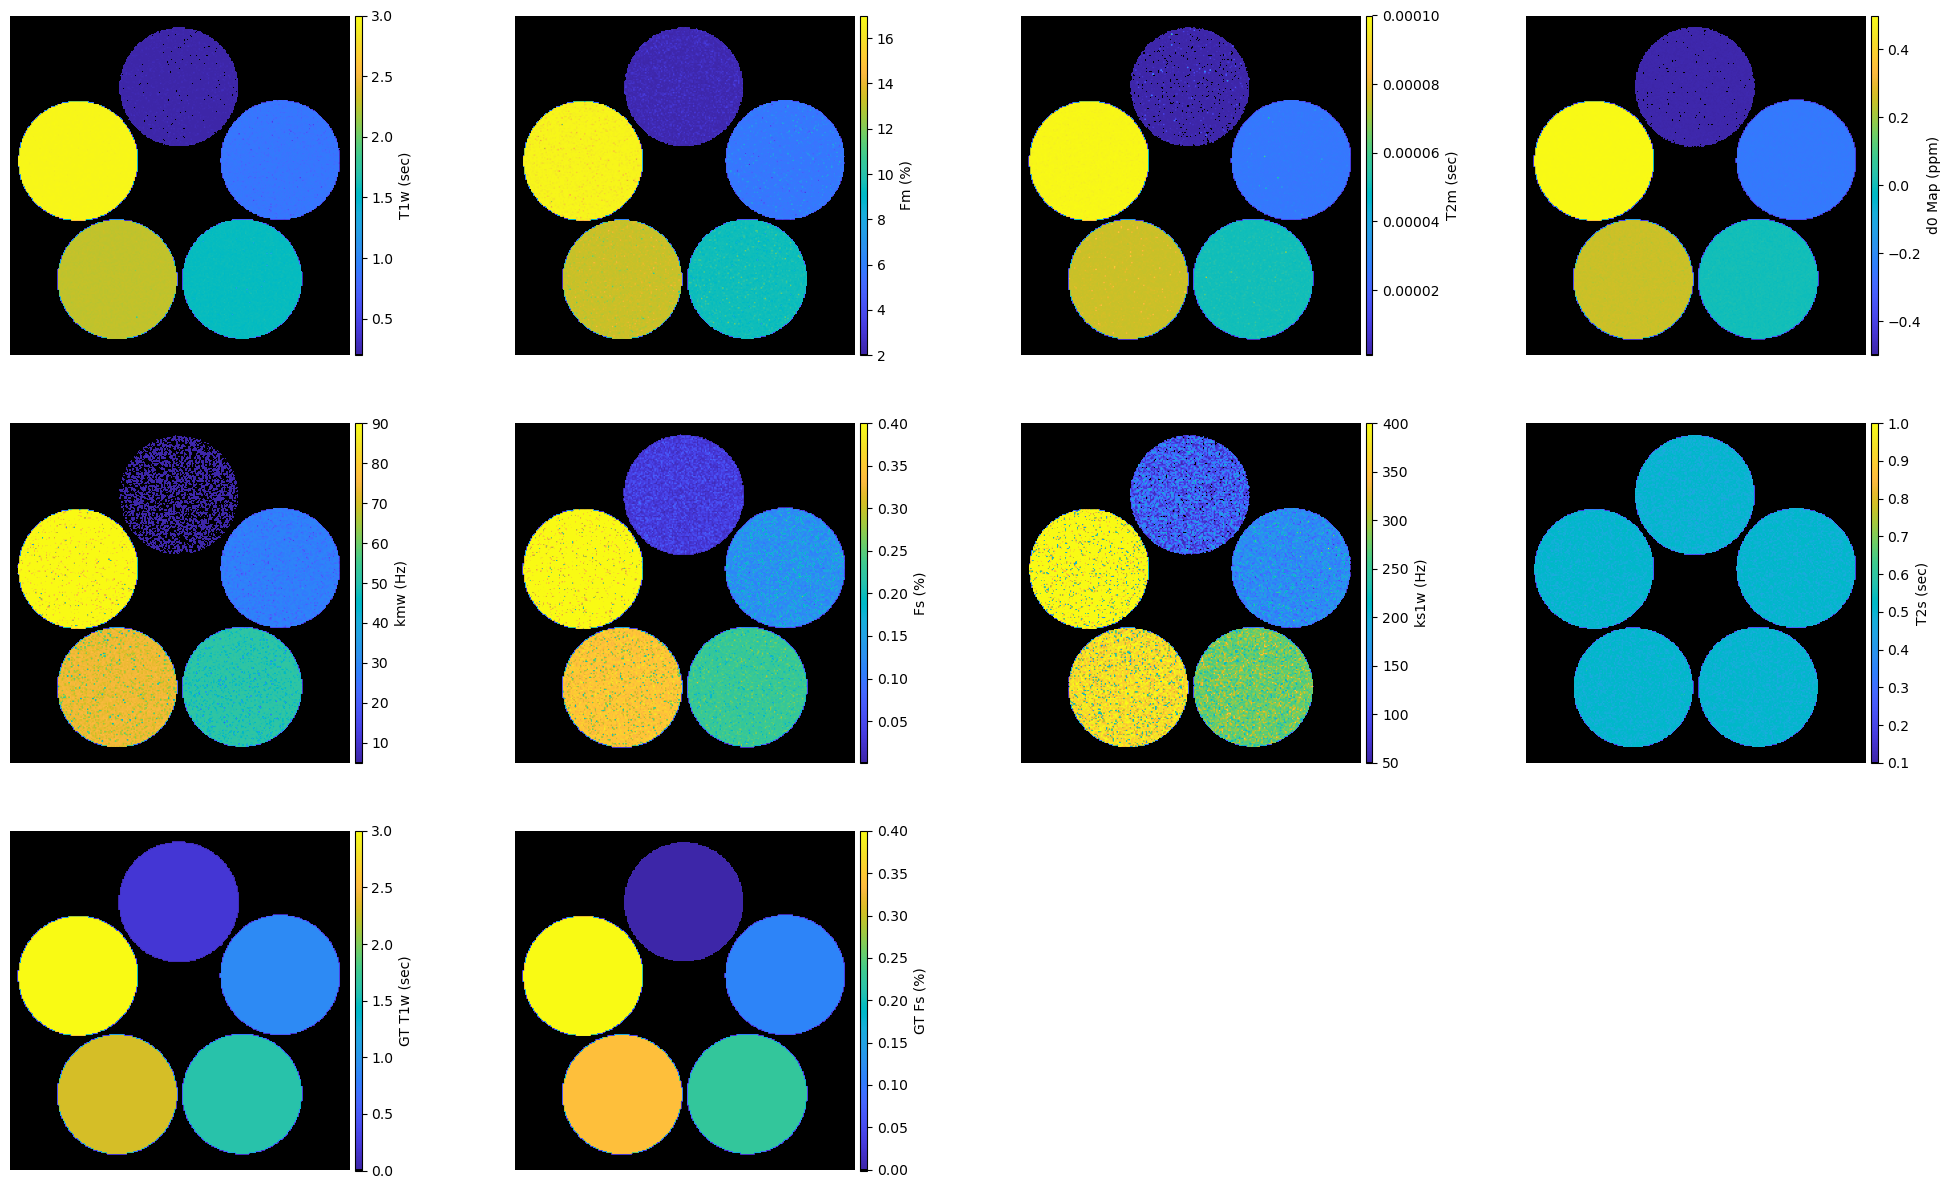

In [25]:
plt.figure(figsize=(25,15))

bx=plt.subplot(3,4,1)
sc=plt.imshow(np.reshape(test_T1w_reshaped,[256,256]), cmap=parula_map)
plt.axis('off')
sc.set_clim(0.2,3)
divider = make_axes_locatable(bx)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(sc, cax=cax)
plt.ylabel('T1w (sec)')

bx=plt.subplot(3,4,2)
st=plt.imshow(np.reshape(test_Fm_reshaped,[256,256])*100, cmap=parula_map)
plt.axis('off')
st.set_clim(2, 17)  ###### .001  .1
divider = make_axes_locatable(bx)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(st, cax=cax)
plt.ylabel('Fm (%)')

bx=plt.subplot(3,4,3)
st=plt.imshow(np.reshape(test_T2m_reshaped,[256,256]), cmap=parula_map)
plt.axis('off')
st.set_clim(0.000001,0.0001)
divider = make_axes_locatable(bx)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(st, cax=cax)
plt.ylabel('T2m (sec)')

bx=plt.subplot(3,4,4)
st=plt.imshow(test_dB0_reshaped*-1, cmap=parula_map)
plt.axis('off')
st.set_clim(-0.5,0.5)
divider = make_axes_locatable(bx)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(st, cax=cax)
plt.ylabel('d0 Map (ppm)')

bx=plt.subplot(3,4,5)
st=plt.imshow(np.reshape(test_kmw_reshaped,[256,256]), cmap=parula_map)
plt.axis('off')
st.set_clim(5,90)
divider = make_axes_locatable(bx)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(st, cax=cax)
plt.ylabel('kmw (Hz)')

bx=plt.subplot(3,4,6)
st=plt.imshow(test_Fs_reshaped*100, cmap=parula_map)
plt.axis('off')
st.set_clim(9.1e-06*100,0.0040*100)
divider = make_axes_locatable(bx)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(st, cax=cax)
plt.ylabel('Fs (%)')

bx=plt.subplot(3,4,7)
st=plt.imshow(test_ksw_reshaped, cmap=parula_map)
plt.axis('off')
st.set_clim(50, 400)
divider = make_axes_locatable(bx)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(st, cax=cax)
plt.ylabel('ks1w (Hz)')

bx=plt.subplot(3,4,8)
st=plt.imshow(test_T2s_reshaped, cmap=parula_map)
plt.axis('off')
st.set_clim(0.1,1)
divider = make_axes_locatable(bx)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(st, cax=cax)
plt.ylabel('T2s (sec)')

bx=plt.subplot(3,4,9)
st=plt.imshow(Phantom_T1w, cmap=parula_map)
plt.axis('off')
st.set_clim(0,3)
divider = make_axes_locatable(bx)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(st, cax=cax)
plt.ylabel('GT T1w (sec)')

bx=plt.subplot(3,4,10)
st=plt.imshow(Phantom_Fs*100, cmap=parula_map)
plt.axis('off')
st.set_clim(-0.001,0.40)
divider = make_axes_locatable(bx)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(st, cax=cax)
plt.ylabel('GT Fs (%)')

In [26]:
## dB0 values got change while masking background to zero 
x_pred_st_mrf_dB0_noisy = model_APT.predict(st_mrf_dB0_noisy)
test_dB0_reshaped = np.transpose(np.reshape(x_pred_st_mrf_dB0_noisy[:,3], [256,256]))
test_dB0_reshaped[Phantom_dB0==0]=0

2048/2048 ━━━━━━━━━━━━━━━━━━━━ 2s 799us/step


In [28]:
## nRMSE
GT_norm_kmw = NormalizeData(Phantom_kmw[Phantom_kmw!=0])
pred_norm_kmw = NormalizeData(test_kmw_reshaped[test_kmw_reshaped!=0]) 
GT_norm_Fm = NormalizeData(Phantom_Fm[Phantom_Fm!=0])
pred_norm_Fm = NormalizeData(test_Fm_reshaped[test_Fm_reshaped!=0])  
GT_norm_T2m = NormalizeData(Phantom_T2m[Phantom_T2m!=0])
pred_norm_T2m = NormalizeData(test_T2m_reshaped[test_T2m_reshaped!=0])   
GT_norm_T1w = NormalizeData(Phantom_T1w[Phantom_T1w!=0])
pred_norm_T1w = NormalizeData(test_T1w_reshaped[test_T1w_reshaped!=0]) 

GT_norm_ksw = NormalizeData(Phantom_ksw[Phantom_ksw!=0])
pred_norm_ksw = NormalizeData(test_ksw_reshaped [test_ksw_reshaped!=0])
GT_norm_Fs = NormalizeData(Phantom_Fs[Phantom_Fs!=0])
pred_norm_Fs = NormalizeData(test_Fs_reshaped[test_Fs_reshaped!=0] )
GT_norm_T2m = NormalizeData(Phantom_T2s[Phantom_T2s!=0])
pred_norm_T2m = NormalizeData(test_T2s_reshaped[test_T2s_reshaped!=0] )
GT_norm_dB0 = NormalizeData(Phantom_dB0[Phantom_dB0!=0])
pred_norm_dB0 = NormalizeData(test_dB0_reshaped[test_dB0_reshaped!=0])   

print('Rm:     ',root_mean_squared_error(GT_norm_kmw, pred_norm_kmw))
print('Mm:     ',root_mean_squared_error(GT_norm_Fm, pred_norm_Fm))
print('T2m:    ',root_mean_squared_error(GT_norm_T2m, pred_norm_T2m))
print('T1w:    ',root_mean_squared_error(GT_norm_T1w, pred_norm_T1w))
print('Rc:     ',root_mean_squared_error(GT_norm_ksw, pred_norm_ksw))
print('Mc:     ',root_mean_squared_error(GT_norm_Fs, pred_norm_Fs ))
print('T2c:    ',root_mean_squared_error(GT_norm_T2m, pred_norm_T2m ))
print('dB0map: ',root_mean_squared_error(GT_norm_dB0, pred_norm_dB0 ))

Rm:      0.05910869469639062
Mm:      0.024498862506782442
T2m:     0.36172828391969686
T1w:     0.01137565087995657
Rc:      0.15666741880070942
Mc:      0.08115495382012668
T2c:     0.36172828391969686
dB0map:  0.006650844259203281
